In [16]:
# We start by loading pytorch and looking at fundamental blocks of pytorch (tensors, etc)

In [17]:
import torch
import numpy as np

x = torch.empty(3, 4) #matrix
print(type(x))
print(x)

zeros = torch.zeros(2, 3, 10)
print(zeros)

ones = torch.ones(2, 3)
print(ones)

torch.manual_seed(1729)
random = torch.rand(2, 3)
print(random)

a = torch.rand(2, 2, requires_grad=True) # turn on autograd
print(a)

b = a.clone() # returns a copy of the input
print(b)

c = a.detach().clone() # returns a new tensor, detached from the current graph (can't differentiate)
print(c)

<class 'torch.Tensor'>
tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])
tensor([[1., 1., 1.],
        [1., 1., 1.]])
tensor([[0.3126, 0.3791, 0.3087],
        [0.0736, 0.4216, 0.0691]])
tensor([[0.2332, 0.4047],
        [0.2162, 0.9927]], requires_grad=True)
tensor([[0.2332, 0.4047],
        [0.2162, 0.9927]], grad_fn=<CloneBackward0>)
tensor([[0.2332, 0.4047],
        [0.2162, 0.9927]])


# We generate a neural network

Consider a scalar function $f(x)=cos(x)$. We want to approximate this using a neural network.

What are the dimensions of the input and output?

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    # we need to instantiate the network and write a forward evaluation of it
    # This object can be differentiated
    def __init__(self, nInput, nOutput, n_hidden=3, n_layers=2):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.n_hidden = n_hidden
        self.input_layer = nn.Linear(nInput, self.n_hidden)
        self.output_layer = nn.Linear(self.n_hidden, nOutput)

        self.hidden_layers = []
        for i in range(n_layers):
          self.hidden_layers.append(nn.Linear(self.n_hidden, self.n_hidden))
        self.hidden_layers = nn.ModuleList(self.hidden_layers)

        # The values are initialized from uniformly sampling U(−k,k), where k = 1/in_features​.
        # https://pytorch.org/docs/stable/generated/torch.nn.Linear.html?highlight=nn+linear#torch.nn.Linear

        self.activation = nn.ReLU() # you can test different activation functions and layers
                                    # https://pytorch.org/docs/stable/nn.html

    def forward(self, x):
        x = self.input_layer(x)
        x = self.activation(x)
        for layer in self.hidden_layers:
          x = layer(x)
          x = self.activation(x)
        x = self.output_layer(x)
        return x

In [19]:
# Scalar problem
nInput = 1
nOutput = 1
net = Net(nInput,nOutput,n_hidden=3)
print(net)

# generate an input
input_tensor = torch.rand(1,nInput) # (nDataPoints, size input)
print(f"Input tensor: {input_tensor}")
print(f"Network output: {net.forward(input_tensor)}")

Net(
  (input_layer): Linear(in_features=1, out_features=3, bias=True)
  (output_layer): Linear(in_features=3, out_features=1, bias=True)
  (hidden_layers): ModuleList(
    (0-1): 2 x Linear(in_features=3, out_features=3, bias=True)
  )
  (activation): ReLU()
)
Input tensor: tensor([[0.6493]])
Network output: tensor([[-0.3126]], grad_fn=<AddmmBackward0>)


In [20]:
# Multi-dimensional problem
nInput = 10
nOutput = 10
net = Net(nInput,nOutput)
print(net)

# generate an input
input_tensor = torch.rand(1,nInput)
print(f"Input tensor: {input_tensor}")
print(f"Network output: {net.forward(input_tensor)}")

Net(
  (input_layer): Linear(in_features=10, out_features=3, bias=True)
  (output_layer): Linear(in_features=3, out_features=10, bias=True)
  (hidden_layers): ModuleList(
    (0-1): 2 x Linear(in_features=3, out_features=3, bias=True)
  )
  (activation): ReLU()
)
Input tensor: tensor([[0.4408, 0.3877, 0.6078, 0.2345, 0.7117, 0.7402, 0.4467, 0.8499, 0.1399,
         0.9280]])
Network output: tensor([[-0.0517, -0.3320, -0.2633, -0.1393,  0.1550, -0.5393,  0.3235, -0.1890,
          0.2211,  0.2091]], grad_fn=<AddmmBackward0>)


In [21]:
import torch.utils.data as data
import torch.optim as optim

import warnings # remove warnings (not nice :) )
warnings.filterwarnings("ignore")

nData = 200
x_train = np.random.uniform(low=0.0, high=1, size=(nData,))
y_train = 1-np.cos(2*np.pi*x_train)

x_test = np.sort(np.random.uniform(low=0.0, high=1.0, size=(50,)))
batch_size = 64

class CustomDataset(data.Dataset):
  def __init__(self, x,y):
        self.x = x
        self.y = y
  def __len__(self):
        return len(self.x)
  def __getitem__(self, idx):
        sample = {'x': self.x[idx], 'y': self.y[idx]}
        return sample

training_data = CustomDataset(x_train,y_train)
training_loader = data.DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=2)

def train_one_epoch(epoch_index,debug=1):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        data_shape = data['x'].shape[0]
        inputs = data['x'].reshape((data_shape,1))
        labels = data['y'].reshape((data_shape,1))
        inputs = torch.tensor(inputs.clone().detach(),dtype=torch.float32)
        labels = torch.tensor(labels.clone().detach(),dtype=torch.float32)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()
        if debug == 1:
          if i == 0:
            grads = {name: params.grad.view(-1).cpu().clone().numpy() for name, params in model.named_parameters() if "weight" in name}
            for key in grads.keys():
              print(f"{key}:{grads[key]}")

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
    scheduler.step()
    #print(f"Loss:{running_loss}")
    return running_loss

In [22]:
import torch.utils.data as data
import torch.optim as optim

import warnings # remove warnings (not nice :) )
warnings.filterwarnings("ignore")

nData = 200
x_train = np.random.uniform(low=0.0, high=1, size=(nData,))
y_train = 1-np.cos(2*np.pi*x_train)

x_test = np.sort(np.random.uniform(low=0.0, high=1.0, size=(50,)))
batch_size = 64

class CustomDataset(data.Dataset):
  def __init__(self, x,y):
        self.x = x
        self.y = y
  def __len__(self):
        return len(self.x)
  def __getitem__(self, idx):
        sample = {'x': self.x[idx], 'y': self.y[idx]}
        return sample

training_data = CustomDataset(x_train,y_train)
training_loader = data.DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=2)

def train_one_epoch(epoch_index,debug=1):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        data_shape = data['x'].shape[0]
        inputs = data['x'].reshape((data_shape,1))
        labels = data['y'].reshape((data_shape,1))
        inputs = torch.tensor(inputs.clone().detach(),dtype=torch.float32)
        labels = torch.tensor(labels.clone().detach(),dtype=torch.float32)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()
        if debug == 1:
          if i == 0:
            grads = {name: params.grad.view(-1).cpu().clone().numpy() for name, params in model.named_parameters() if "weight" in name}
            for key in grads.keys():
              print(f"{key}:{grads[key]}")

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
    return running_loss

In [23]:
def init_weights_zero(m):
    if isinstance(m, nn.Linear):
          m.weight.data.fill_(0.0)
          m.bias.data.fill_(0.0)

def init_weights_constant(m):
    if isinstance(m, nn.Linear):
          m.weight.data.fill_(1.0)
          m.bias.data.fill_(1.0)

def init_weights_xavier(m):
    if isinstance(m, nn.Linear):
          torch.nn.init.xavier_uniform_(m.weight)
          m.bias.data.fill_(0.01)

In [24]:
for initialisation_type, initialisation in zip(['zeros','constant','xavier'],[init_weights_zero, init_weights_constant, init_weights_xavier]):
  model = Net(1,1,n_hidden=3)
  model.apply(initialisation)

  loss_fn = torch.nn.MSELoss()

  optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

  print(f"Initialisation type: {initialisation_type}")
  for i in range(10):
    _ = train_one_epoch(i,debug=1)


Initialisation type: zeros
input_layer.weight:[0. 0. 0.]
output_layer.weight:[0. 0. 0.]
hidden_layers.0.weight:[0. 0. 0. 0. 0. 0. 0. 0. 0.]
hidden_layers.1.weight:[0. 0. 0. 0. 0. 0. 0. 0. 0.]
input_layer.weight:[0. 0. 0.]
output_layer.weight:[0. 0. 0.]
hidden_layers.0.weight:[0. 0. 0. 0. 0. 0. 0. 0. 0.]
hidden_layers.1.weight:[0. 0. 0. 0. 0. 0. 0. 0. 0.]
input_layer.weight:[0. 0. 0.]
output_layer.weight:[0. 0. 0.]
hidden_layers.0.weight:[0. 0. 0. 0. 0. 0. 0. 0. 0.]
hidden_layers.1.weight:[0. 0. 0. 0. 0. 0. 0. 0. 0.]
input_layer.weight:[0. 0. 0.]
output_layer.weight:[0. 0. 0.]
hidden_layers.0.weight:[0. 0. 0. 0. 0. 0. 0. 0. 0.]
hidden_layers.1.weight:[0. 0. 0. 0. 0. 0. 0. 0. 0.]
input_layer.weight:[0. 0. 0.]
output_layer.weight:[0. 0. 0.]
hidden_layers.0.weight:[0. 0. 0. 0. 0. 0. 0. 0. 0.]
hidden_layers.1.weight:[0. 0. 0. 0. 0. 0. 0. 0. 0.]
input_layer.weight:[0. 0. 0.]
output_layer.weight:[0. 0. 0.]
hidden_layers.0.weight:[0. 0. 0. 0. 0. 0. 0. 0. 0.]
hidden_layers.1.weight:[0. 0. 0. 0.

# Optimizers

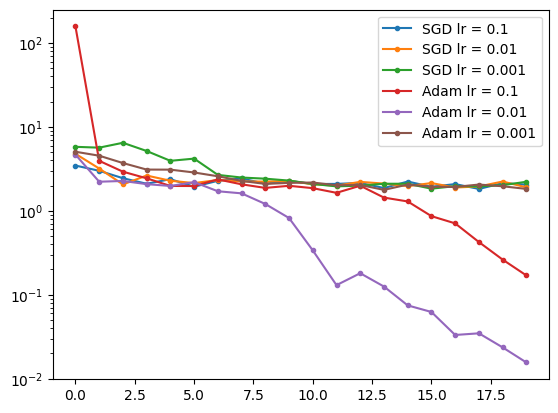

In [52]:
from matplotlib import pyplot as plt
import copy

models = {}
for optimizer_type in ['SGD','Adam']:
  for lr in [0.1,0.01,0.001]:
    losses = []
    model = Net(1,1,n_hidden=50, n_layers=3)

    loss_fn = torch.nn.MSELoss()
    if optimizer_type == 'SGD':
      optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    elif optimizer_type == 'Adam':
      optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for i in range(20):
      losses.append(train_one_epoch(i,debug=0))

    plt.semilogy(losses,label=f'{optimizer_type} lr = {lr}',marker='.')
    plt.legend()
    models[f"{optimizer_type}_{lr}"] = copy.deepcopy(model)


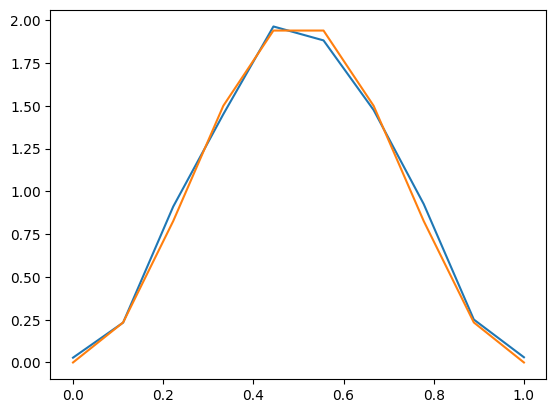

In [53]:
plt.plot(torch.linspace(0,1,10),models[f"Adam_0.01"](torch.linspace(0,1,10).unsqueeze(1)).detach().numpy())
plt.plot(torch.linspace(0,1,10),1-np.cos(2*np.pi*torch.linspace(0,1,10)))

# Convolutional Neural Networks

In [ ]:
# Load MNIST

import torchvision
import torchvision.transforms as transforms

BATCH_SIZE = 32

## transformations
transform = transforms.Compose(
    [transforms.ToTensor()])

## download and load training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

## download and load testing dataset
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)


classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

100%|██████████| 9.91M/9.91M [00:00<00:00, 37.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.20MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.2MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.82MB/s]


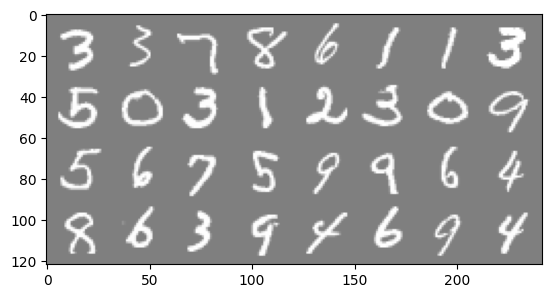

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))


In [ ]:
# set up CNNs
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5) # (in channels, out channels, kernel size) https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d
        self.pool = nn.MaxPool2d(2, 2) # kernel_size
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*4*4, 120) # a bit nasty, should catch the size without hardcoding it...
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = self.pool(self.conv1(x)) # F.relu() seems to improve convergence (idk why)
        x = self.pool(self.conv2(x)) # F.relu()
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Net()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')


[1,   100] loss: 0.115
[1,   200] loss: 0.113
[1,   300] loss: 0.110
[1,   400] loss: 0.096
[1,   500] loss: 0.055
[1,   600] loss: 0.034
[1,   700] loss: 0.025
[1,   800] loss: 0.021
[1,   900] loss: 0.019
[1,  1000] loss: 0.019
[1,  1100] loss: 0.018
[1,  1200] loss: 0.016
[1,  1300] loss: 0.015
[1,  1400] loss: 0.016
[1,  1500] loss: 0.014
[1,  1600] loss: 0.013
[1,  1700] loss: 0.011
[1,  1800] loss: 0.011
[2,   100] loss: 0.010
[2,   200] loss: 0.011
[2,   300] loss: 0.010
[2,   400] loss: 0.011
[2,   500] loss: 0.009
[2,   600] loss: 0.010
[2,   700] loss: 0.010
[2,   800] loss: 0.009
[2,   900] loss: 0.009
[2,  1000] loss: 0.009
[2,  1100] loss: 0.008
[2,  1200] loss: 0.009
[2,  1300] loss: 0.007
[2,  1400] loss: 0.008
[2,  1500] loss: 0.008
[2,  1600] loss: 0.007
[2,  1700] loss: 0.007
[2,  1800] loss: 0.007
Finished Training


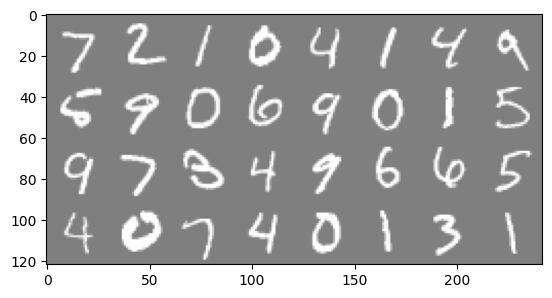

Predicted:  7     2     1     0     4     1     4     9    


In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(8)))